In [1]:
using Pkg
Pkg.activate("C:/Users/ibzja/Documents/UPF_2022_2026/4t/2n_trimestre/Practiques_tutelades/CellBasedModels.jl")
using CellBasedModels 
using GeometryBasics
using Distributions
using GLMakie
Makie.inline!(true)

  Activating project at `C:\Users\ibzja\Documents\UPF_2022_2026\4t\2n_trimestre\Practiques_tutelades\CellBasedModels.jl`


true

In [2]:
function plotRods2D!(ax, x, y, d, l, angle; kargs...)

    Main.meshscatter!(ax,
                x.+l./2 .*cos.(angle),
                y.+l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )

    Main.meshscatter!(ax,
                x.-l./2 .*cos.(angle),
                y.-l./2 .*sin.(angle),
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=[
                    Point3f(i/2,i/2,0)
                    for i in d
                ],
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=[Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(l,d)],
                rotation=angle,
                kargs...
            )

    return

end

function plotRods2D!(ax, x, y, xs1, ys1, xs2, ys2, markerSphere, markerCylinder, angle; kargs...)

    m = meshscatter!(ax,
                xs1,
                ys1,
                marker=Sphere(Point3f(0,0,0.),Float32(1)),
                markersize=markerSphere;
                kargs...
            )

    Main.meshscatter!(ax,
                xs2,
                ys2,
                marker=Sphere(Point3f(0,0,0),Float32(1)),
                markersize=markerSphere;
                kargs...
            )
            
    Main.meshscatter!(ax,
                x,
                y,
                marker=Cylinder(Point3f(-.5,0,0),Point3f(.5,0,0),Float32(1)),
                markersize=markerCylinder,
                rotation=angle;
                kargs...
            )

    return m

end

plotRods2D! (generic function with 2 methods)

# Dufour et al. 2014 chemotaxis model


In [3]:
rods2DChemotaxis = ABM(2,
    agent = Dict(
        :vx => Float64,
        :vy => Float64,
        :theta => Float64,
        :ω => Float64,
        :d => Float64,
        :l => Float64,
        :m => Float64,
        :fx => Float64,
        :fy => Float64,
        :W => Float64,
        :pressure => Float64,
        :tTumble => Float64,
        :active => Bool,

        :isSource => Bool,
        :S => Float64,

        :methyl => Float64, #Receptor methylation
        :Yp => Float64 #CheYP levels, probability of tumbling

    ),

    model = Dict(
        :kn => Float64,
        :γn => Float64,
        :γt => Float64,
        :μcc => Float64,
        :μcw => Float64,
        :β => Float64,
        :βω => Float64,
        :ωTumble => Float64,
        # :τTumble => Float64,
        :fChem => Float64,
        :DMedium => Float64,
        :DSource => Float64,

        :ε0 => Float64, #Energy parameters
        :ε1 => Float64,
        :Nrec => Float64, #Cooperativity
        :Ki => Float64, #Dissociation constants
        :Ka => Float64,
        :τm => Float64, #Methylation adaptation timescale
        :A0 => Float64,
        :Yp0 => Float64,
        :α => Float64,
        :λ0 => Float64
    ),

    medium = Dict(
        :mm => Float64
    ),

    agentODE = quote
        L = max(mm, 1e-12)  #Concentration, avoid log(0)
        F = ε0 + ε1 * methyl + Nrec * log((1 + L / Ki) / (1 + L / Ka)) #Equació del paper per definir activitat del receptor
        

        A = 1 / (1 + exp(F)) #Receptor activity
        dt(methyl) = (A0 - A) / τm   #Adaptation
        Yp = Yp0 + α * (A - A0)  #CheYP activity depenent on adaptation
        
        fx = 0.0
        fy = 0.0
        W = 0.0
        pressure = 0.0

        @loopOverNeighbors j begin
            Fijx, Fijy, Wij = CBMModels.rodForces(
                x, y, d, l, theta, vx, vy, m,
                x[j], y[j], d[j], l[j], theta[j], vx[j], vy[j], m[j],
                kn, γn, γt, μcc, μcw
            )

            fx += Fijx
            fy += Fijy
            W += Wij
            pressure += sqrt(Fijx^2 + Fijy^2)
        end

        dt(x) = vx
        dt(y) = vy
        dt(vx) = -β * vx + fx / m + active * fChem * cos(theta)
        dt(vy) = -β * vy + fy / m + active * fChem * sin(theta)
        dt(theta) = ω
        dt(ω) = W / (m * (d + l)^2 / 12 + m * d^2) - βω * ω

    end,

    agentRule = quote

        if isSource
            σ = sqrt(2 * DSource / dt)

            vx = σ * randn()
            vy = σ * randn()
            ω = 0.0

            mm += S
        end

        if tTumble < t && active
            vx = 0.0
            vy = 0.0
            active = false
            ω += ωTumble
            tTumble += 1.0
        elseif tTumble < t && !active
            ω = 0.0
            active = true
            λ = λ0 * (Yp /Yp0)
            tTumble += CBMDistributions.exponential(1 / λ)   #Large lambda = shorter time = more switching
        end
 
        if x < simBox[1,1]
            x = simBox[1,1]
        elseif x > simBox[1,2]
            x = simBox[1,2]
        end
        if y < simBox[2,1]
            y = simBox[2,1]
        elseif y > simBox[2,2]
            y = simBox[2,2]
        end
    end,

    mediumODE = quote
        if @mediumInside()
            dt(mm) = DMedium *(@∂2(1, mm)+ @∂2(2, mm))
        end
    end,

    neighborsAlg = CBMNeighbors.CellLinked(cellEdge = 4)
)

PARAMETERS
	x (Float64 agent)
	y (Float64 agent)
	xₘ (Float64 medium)
	yₘ (Float64 medium)
	d (Float64 agent)
	active (Bool agent)
	isSource (Bool agent)
	fx (Float64 agent)
	methyl (Float64 agent)
	vx (Float64 agent)
	l (Float64 agent)
	m (Float64 agent)
	fy (Float64 agent)
	Yp (Float64 agent)
	pressure (Float64 agent)
	vy (Float64 agent)
	ω (Float64 agent)
	W (Float64 agent)
	S (Float64 agent)
	tTumble (Float64 agent)
	theta (Float64 agent)
	ε1 (Float64 model)
	α (Float64 model)
	γn (Float64 model)
	μcw (Float64 model)
	ωTumble (Float64 model)
	Ka (Float64 model)
	β (Float64 model)
	DMedium (Float64 model)
	ε0 (Float64 model)
	λ0 (Float64 model)
	γt (Float64 model)
	μcc (Float64 model)
	A0 (Float64 model)
	kn (Float64 model)
	fChem (Float64 model)
	Nrec (Float64 model)
	βω (Float64 model)
	Yp0 (Float64 model)
	τm (Float64 model)
	DSource (Float64 model)
	Ki (Float64 model)
	mm (Float64 medium)


UPDATE RULES
mediumODE
 if @mediumInside()
    dt__mm = DMedium * (@∂2(1, mm) + @∂2(2, mm

In [7]:
com = Community(
    rods2DChemotaxis,
    N=75,
    dt=0.1,
    simBox=[-20 20;-20 20.],
    NMedium=[200,200],
)

m = 1/100
g = 1/10000
d = 1

com.kn = 2E6      * (m*g/d)
com.γn = 2.2E2    * sqrt(g/d)
com.γt = 2.2E2    * sqrt(g/d)
com.μcc = 0.1
com.μcw = 0.8
com.β = .8
com.βω = .8
com.fChem = 0.0
# com.τTumble = 2
com.Ki = 18.0
com.Ka = 3.0
com.Nrec = 6.0
com.ε0   = 0.0
com.ε1   = 1.0
com.A0 = 0.5
com.τm = 10.0
com.α   = 3.0
com.Yp0 = 1.0   
com.λ0 = 1.0

com.ωTumble = 1
com.DMedium = 0.00
com.DSource = 0.07

com.m = 1.        
com.d = 1.        
com.l = 3;

com.x = rand(Uniform(com.simBox[1,:]...),com.N)
com.y = rand(Uniform(com.simBox[2,:]...),com.N)
com.theta = rand(Uniform(0,2π),com.N)
com.methyl .= 0.0
com.Yp .= com.Yp0

com.active = true

src = 1

# com.active[src] = false 
com.isSource .= false
# com.isSource[src] = true

com.S = 0.0
# com.S[src] = 2.0

Nx, Ny = com.NMedium        #Added test for fixed gradient background
xvals = range(com.simBox[1,1], com.simBox[1,2], length = Nx)

for i in 1:Nx, j in 1:Ny
    com.mm[i, j] = 0.1 + 0.05 * (xvals[i] - com.simBox[1,1])
end

In [8]:
evolve!(com, steps = 1000, saveEach = 10)

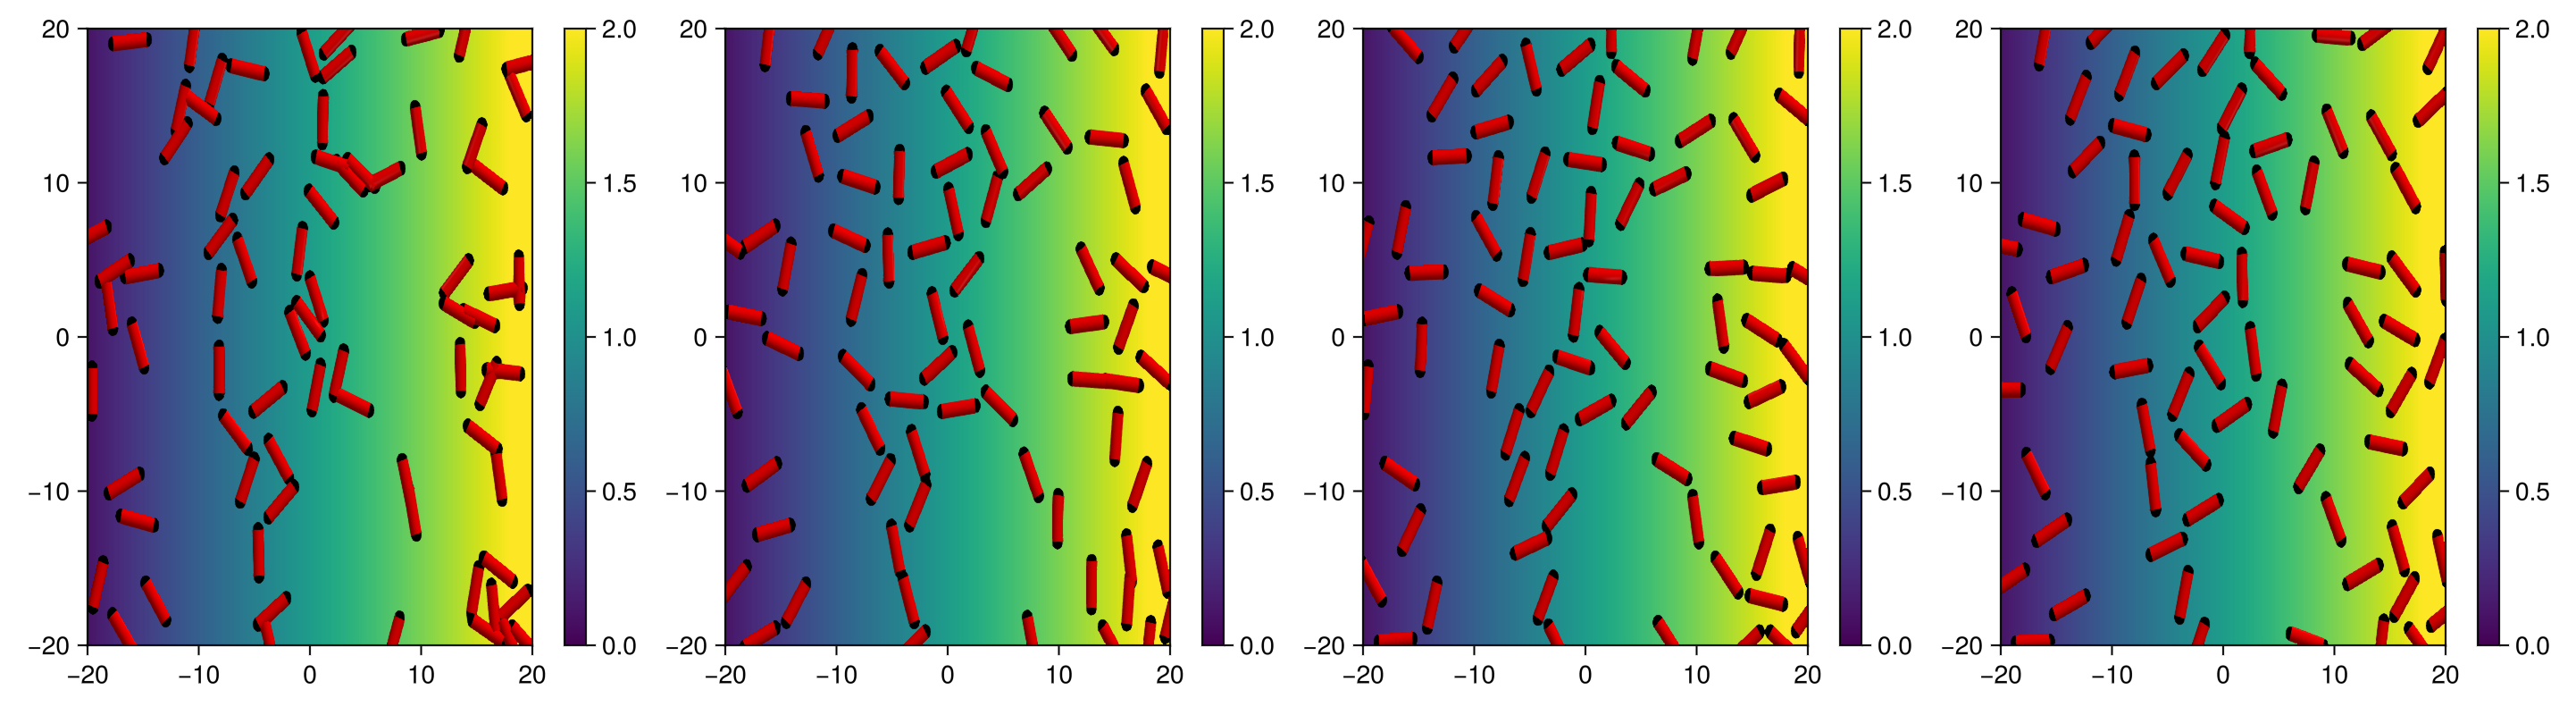

GLMakie.Screen(...)

In [9]:
fig = Figure(size=(1800, 400))

for (j,i) in enumerate(1:round(Int,length(com)/4):length(com))
    begin
        d = getParameter(com, [:x,:y,:d,:l,:theta,:pressure,:mm, :isSource])

        ax = Axis(fig[1,2*j-1])

        m = heatmap!(ax,
                range(com.simBox[1,1],com.simBox[1,2],length=size(com.mm)[1]),
                range(com.simBox[2,1],com.simBox[2,2],length=size(com.mm)[1]),
                d[:mm][i],
                colorrange=(0,2.)
        )

        xlims!(com.simBox[1,:]...)
        ylims!(com.simBox[2,:]...)

        src = findall(d[:isSource][i])
        scatter!(
            ax, 
            d[:x][i][src],
            d[:y][i][src],
            color = :cyan,
            markersize = 20
        )

        x = Observable(d[:x][i])
        y = Observable(d[:y][i])
        xs1 = Observable(d[:x][i]+d[:l][i]./2 .*cos.(d[:theta][i]))
        ys1 = Observable(d[:y][i]+d[:l][i]./2 .*sin.(d[:theta][i]))
        xs2 = Observable(d[:x][i]-d[:l][i]./2 .*cos.(d[:theta][i]))
        ys2 = Observable(d[:y][i]-d[:l][i]./2 .*sin.(d[:theta][i]))
        ms = Observable([Point3f(i/2,i/2,0) for i in d[:d][i]])
        mc = Observable([Point3f(ll,dd/2,dd/2) for (ll,dd) in zip(d[:l][i],d[:d][i])])
        theta = Observable(d[:theta][i])

        plotRods2D!(ax,x,y,xs1,ys1,xs2,ys2,ms,mc,theta,color=:red)

        Colorbar(fig[1,2*j],m)


    end
end

display(fig)

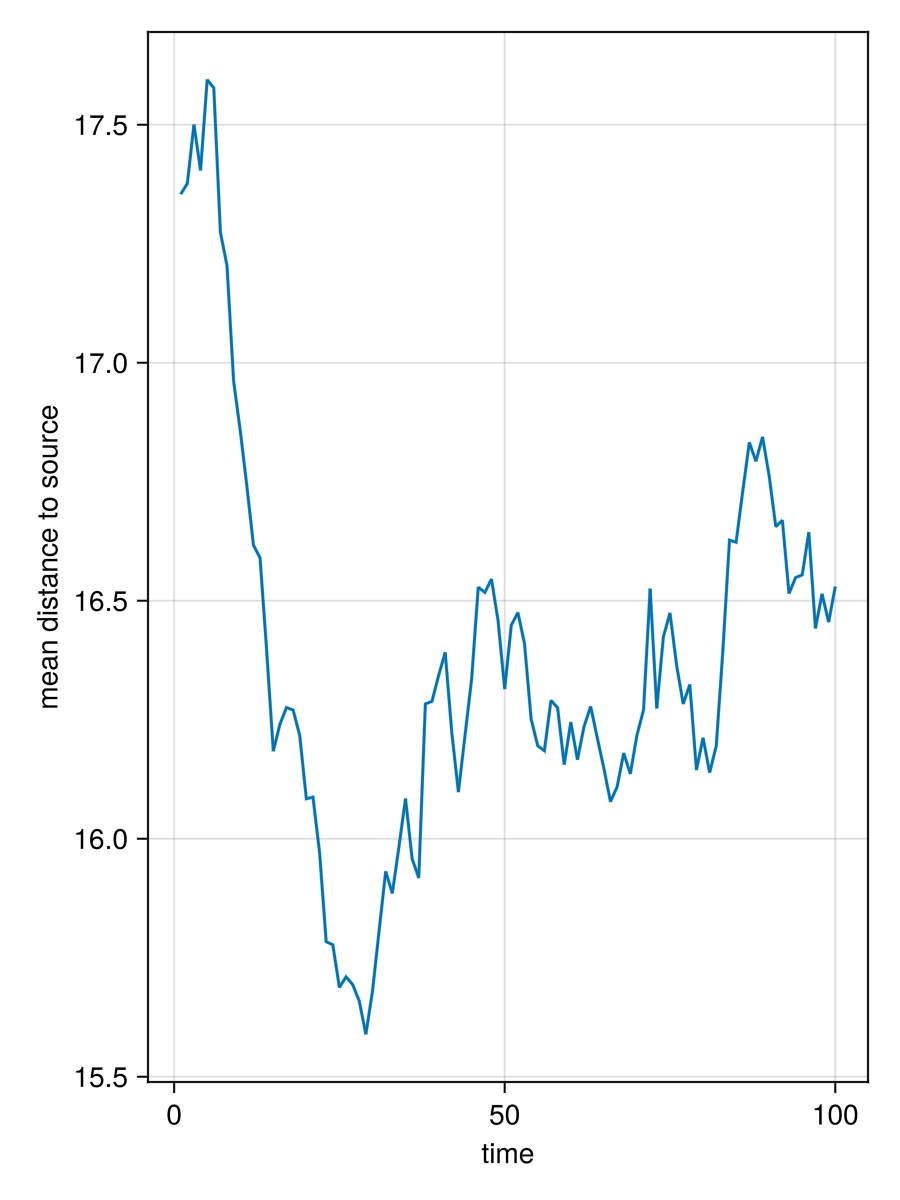

GLMakie.Screen(...)

In [23]:
using Statistics

d = getParameter(com, [:x, :y, :S, :isSource])

src_id = findfirst(d[:isSource][1])

t = [pt.t for pt in com.pastTimes]

# mean distance to source
mean_dist = [
    mean(
        sqrt.(
            (d[:x][k] .- d[:x][k][src_id]).^2 .+
            (d[:y][k] .- d[:y][k][src_id]).^2
        )[.!d[:isSource][k]]
    )
    for k in eachindex(t)
]

fig = Figure(size=(450, 600))

ax1 = Axis(fig[1,1], xlabel="time", ylabel="mean distance to source")
lines!(ax1, t, mean_dist)

display(fig)